### Saving and Monitoring Progress

https://emcee.readthedocs.io/en/stable/tutorials/monitor/

In [7]:
import emcee
import numpy as np

np.random.seed(42)


# The definition of the log probability function
# We'll also use the "blobs" feature to track the "log prior" for each step
def log_prob(theta):
    log_prior = -0.5 * np.sum((theta - 1.0) ** 2 / 100.0)
    log_prob = -0.5 * np.sum(theta**2) + log_prior
    return log_prob, log_prior


# Initialize the walkers
coords = np.random.randn(32, 5)
nwalkers, ndim = coords.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, backend=backend)

In [8]:
max_n = 100000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(coords, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

  6%|███▊                                                             | 5900/100000 [03:24<54:27, 28.80it/s]


Text(0, 0.5, 'mean $\\hat{\\tau}$')

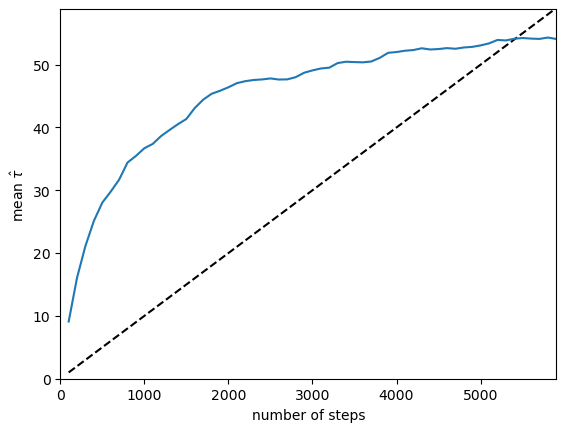

In [9]:
import matplotlib.pyplot as plt

n = 100 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$")

burn-in: 117
thin: 24
flat chain shape: (7680, 5)
flat log prob shape: (7680,)
flat log prior shape: (7680,)


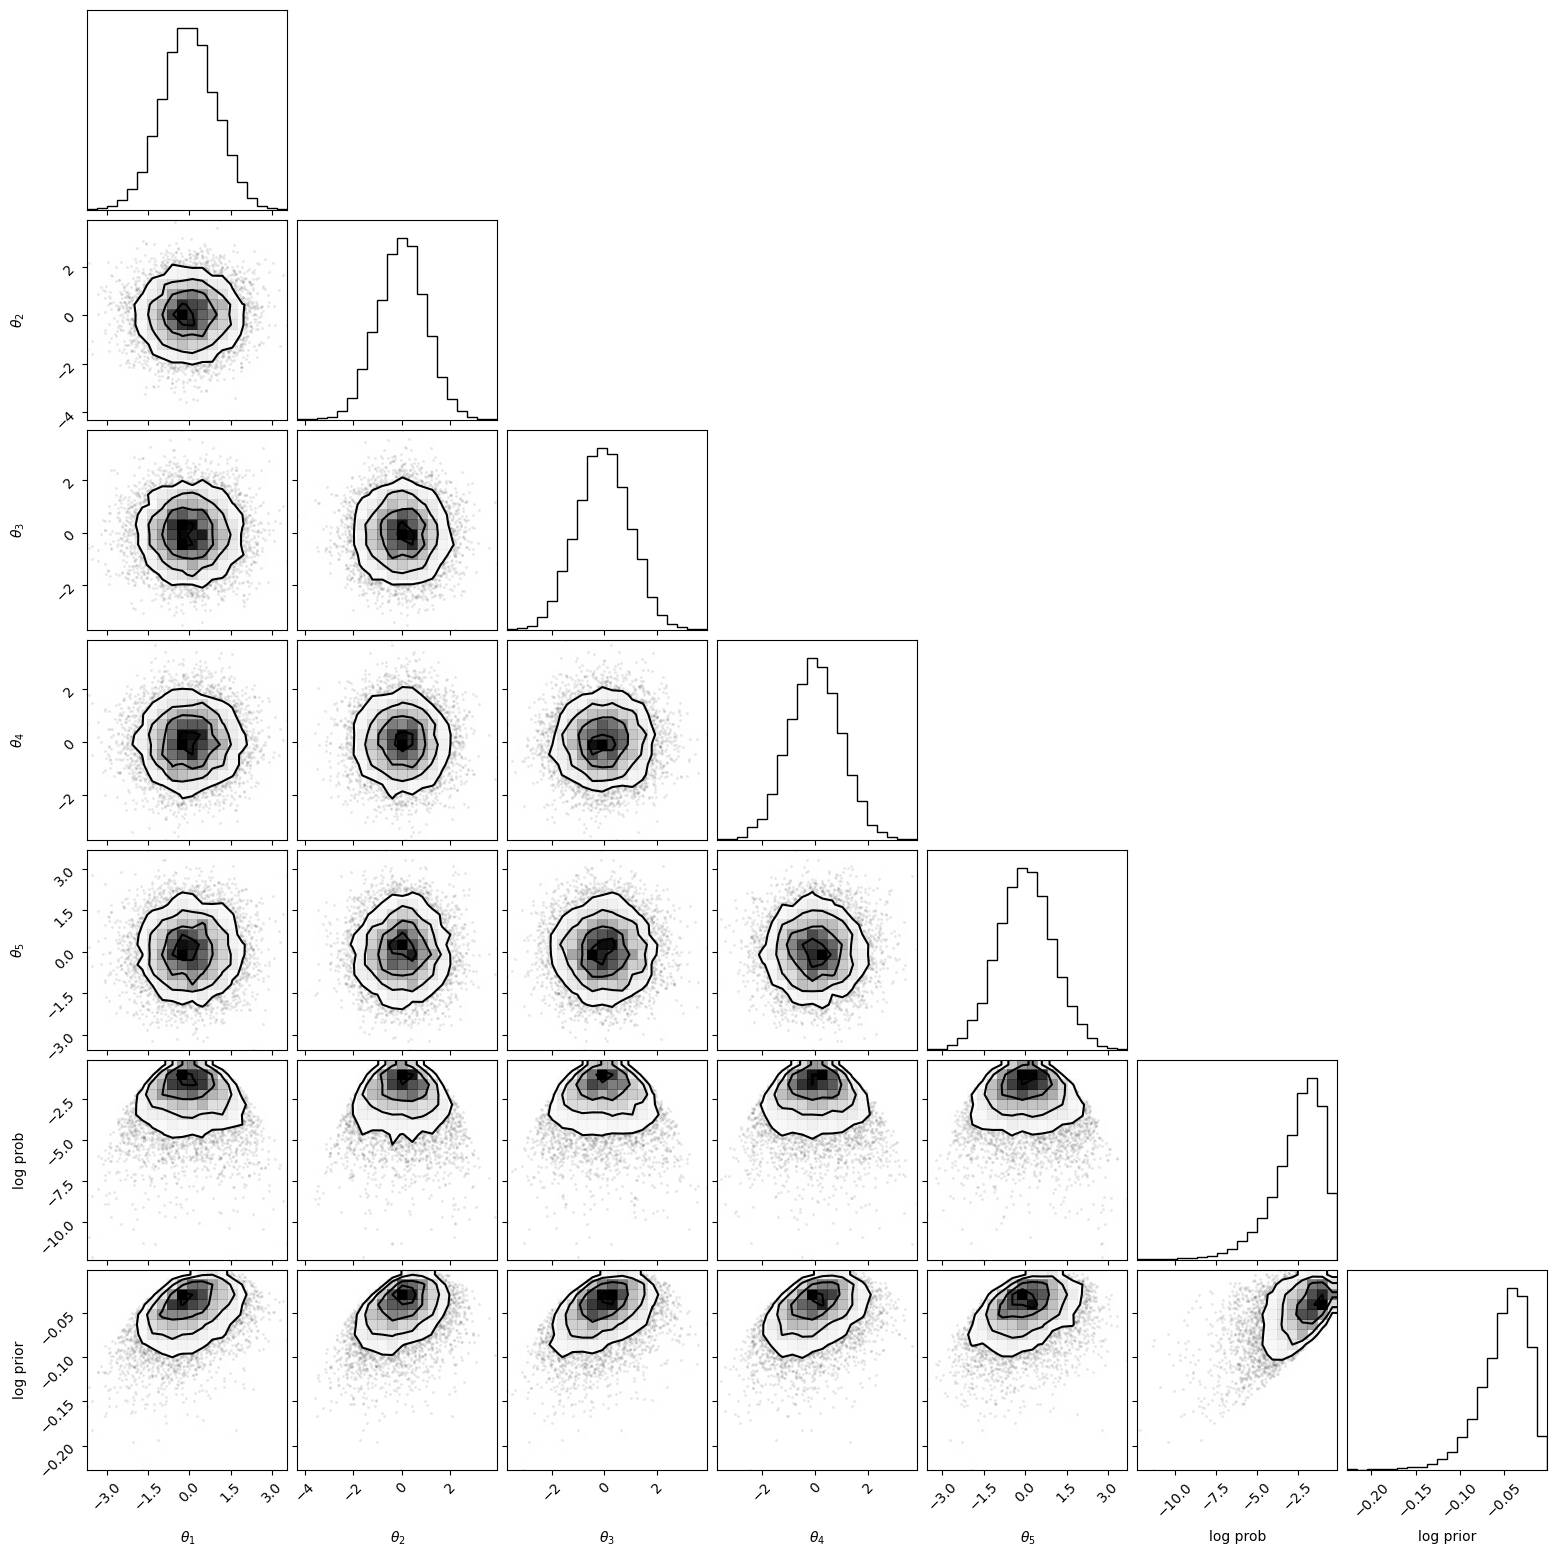

In [ ]:
# Assess all the properties of the chain

import corner

tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

all_samples = np.concatenate(
    (samples, log_prob_samples[:, None], log_prior_samples[:, None]), axis=1
)

labels = list(map(r"$\theta_{{{0}}}$".format, range(1, ndim + 1)))
labels += ["log prob", "log prior"]

corner.corner(all_samples, labels=labels)

In [ ]:
# Can also read the same data from the saved file

reader = emcee.backends.HDFBackend(filename)

tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

burn-in: 117
thin: 24
flat chain shape: (7680, 5)
flat log prob shape: (7680,)
flat log prior shape: (7680,)


In [13]:
# Restart from the last sample

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))
new_sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, backend=new_backend
)
new_sampler.run_mcmc(None, 100)
print("Final size: {0}".format(new_backend.iteration))

Initial size: 5900
Final size: 6000


In [14]:
# Saving another run on the same file

run2_backend = emcee.backends.HDFBackend(filename, name="mcmc_second_prior")

# this time, with a subtly different prior
def log_prob2(theta):
    log_prior = -0.5 * np.sum((theta - 2.0) ** 2 / 100.0)
    log_prob = -0.5 * np.sum(theta**2) + log_prior
    return log_prob, log_prior

# Rinse, Wash, and Repeat as above
coords = np.random.randn(32, 5)
nwalkers, ndim = coords.shape
sampler2 = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob2, backend=run2_backend
)

# note: this is *not* necessarily the right number of iterations for this
# new prior.  But it will suffice  to demonstrate the second backend.
sampler2.run_mcmc(coords, new_backend.iteration, progress=True)

100%|███████████████████████████████████████████████████████████████████| 6000/6000 [02:53<00:00, 34.50it/s]


State([[ 8.91625011e-02 -1.07686452e+00 -9.53332541e-01 -1.61668963e-01
   1.97498755e-01]
 [-2.75007117e-02 -2.38482344e-01  8.93727056e-01  2.35302219e+00
   4.82474044e-02]
 [-4.98036852e-01 -2.73154947e-01 -4.26148884e-01 -1.04722542e-01
  -4.48541558e-01]
 [-2.41959407e-01 -8.50509916e-01  1.07144890e-01 -7.31921055e-01
   4.21341476e-01]
 [ 1.04210539e+00  3.13770124e-03  1.24608409e+00 -2.92909999e-01
  -1.39886369e-01]
 [ 3.16340237e+00  1.86324435e+00 -7.61774856e-01 -8.70047578e-01
   1.67346134e+00]
 [-1.72457494e+00 -1.19690659e-01  6.67665722e-02  3.41563500e-01
  -1.75076456e+00]
 [-1.84108100e+00 -2.19784806e+00 -1.26566332e+00 -9.23403553e-01
  -5.60713254e-01]
 [-2.49135105e+00  1.37106689e+00 -1.78292796e+00 -4.84144869e-01
  -1.18113838e+00]
 [-6.35133120e-01 -1.26460037e+00 -1.59159322e-01 -1.14485762e+00
  -1.75436061e-01]
 [-4.01986707e-01  1.44497454e+00  1.07640784e-02 -3.06769544e-01
   1.25092421e+00]
 [-8.13505526e-02  5.54250418e-02 -6.41079127e-01  4.763715

In [15]:
import h5py

with h5py.File(filename, "r") as f:
    print(list(f.keys()))

['mcmc', 'mcmc_second_prior']
